In [161]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator

!date
!whoami
!pwd

Fri Oct 10 00:39:40 PDT 2025
ndbs
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


# V&V list

# Find data

In [162]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [163]:
# Results directory containing model 6 results for all locations
!ls -halt results/model6.1/united_states_of_america/2025_10_08_10_41_07/results

total 29M
drwxrwsr-x 5 sbachmei IHME-Simulationscience 4.5K Oct  8 11:01 ..
drwxrwsr-x 2 sbachmei IHME-Simulationscience 5.5K Oct  8 11:01 .
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 571K Oct  8 11:01 counts_new_simulants.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 5.6M Oct  8 11:01 ylls.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 2.9M Oct  8 11:01 person_time_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  11M Oct  8 11:01 ylds.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 431K Oct  8 11:01 counts_bbbm_tests.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 777K Oct  8 11:01 counts_newly_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 4.0M Oct  8 11:01 person_time_ever_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 1.5M Oct  8 11:01 counts_baseline_tests_among_eligible.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 923K Oct  8 11:01 deaths.pa

In [164]:
!ls results/model6.0/model_spec/2025_10_03_12_33_34/

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [ ]:
locations = [
    'United States of America',
    # 'Brazil',
    # 'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations}| {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# Select a subset of locations to draw plots for
locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

model_number = '6.0' # Artifacts are stored here
run_subdirectories = [
    'results/model6.1/united_states_of_america/2025_10_08_10_41_07/',
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# Option 1: One results directory per location
location_to_results_dir = {
    loc: path for loc, path in zip(locations, results_dirs)}

# # Option 2: All locations in one results directory
# location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
artifact_path_to_location = {path: loc for loc, path in location_to_artifact_path.items()}
# artifact_path_to_location = {project_dir + subpath: loc for subpath, loc in zip(artifact_subpaths, locations)}
artifact_path_to_location

{'/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/united_states_of_america.hdf': 'United States of America'}

# Get list of draws and draw columns from `keyspace.yaml`, and reduce to a subset of draws to save memory and time

In [166]:
with open(run_dirs[0] + 'keyspace.yaml', 'r') as keyspace_file:
    keyspace = yaml.safe_load(keyspace_file)
draws = keyspace['input_draw']
print(draws)

[457, 169, 323, 392, 346, 480, 258, 446, 356, 273, 158, 24, 265, 317, 177, 199, 2, 13, 46, 89, 41, 113, 262, 460, 499]


In [167]:
# I ended up never actually using this -- I just used all the draws
draws = sorted(draws[:10]) # reduce to a subset of draws to save memory, and sort
draw_cols = [f'draw_{i}' for i in draws]
print(draw_cols)

['draw_169', 'draw_258', 'draw_273', 'draw_323', 'draw_346', 'draw_356', 'draw_392', 'draw_446', 'draw_457', 'draw_480']


# Load one artifact and define age bins

In [168]:
usa_artifact_path = location_to_artifact_path['United States of America']
usa_art = Artifact(usa_artifact_path)
print(usa_art.load('metadata.locations'))
print(usa_art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet



In [169]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = usa_art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54
10,16,55 to 59,55.0,60.0,55_to_59
11,17,60 to 64,60.0,65.0,60_to_64
12,18,65 to 69,65.0,70.0,65_to_69
13,19,70 to 74,70.0,75.0,70_to_74


In [170]:
age_bins.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19 entries, (6, '5 to 9', 5.0, 10.0) to (235, '95 plus', 95.0, 125.0)
Empty DataFrame


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [171]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Load CSF and PET testing rates

In [172]:
# NOTE: Dropping level 1 of index because it is meaningless, containing
# all 0s: 
# https://github.com/ihmeuw/vivarium_csu_alzheimers/blob/7674a25da52e8b9ee23c0184a2e65c6f53aac335/src/vivarium_csu_alzheimers/data/loader.py#L487-L489
csf_rates = load_artifact_data('testing_rates.csf').droplevel(1)
pet_rates = load_artifact_data('testing_rates.pet').droplevel(1)
existing_test_rates = (
    pd.concat(
        {'csf': csf_rates, 'pet': pet_rates}, names=['test_type', 'location'])
    .rename_axis(columns='input_draw')
)
existing_test_rates

,input_draw,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_490,draw_491,draw_492,draw_493,draw_494,draw_495,draw_496,draw_497,draw_498,draw_499
test_type,location,,,,,,,,,,,,,,,,,,,,,
csf,United States of America,0.086170,0.140511,0.102449,0.092320,0.126445,0.062653,0.118921,0.087192,0.096971,0.095522,...,0.131668,0.137619,0.117952,0.089317,0.107378,0.123519,0.079365,0.137440,0.123465,0.089654
pet,United States of America,0.172089,0.196148,0.165458,0.088834,0.164784,0.180419,0.178008,0.223862,0.120794,0.154591,...,0.160961,0.236646,0.166553,0.113526,0.101062,0.201854,0.180972,0.164552,0.150534,0.096107


In [173]:
existing_test_rates.stack().rename('value').to_frame()

value
test_type location                 input_draw          
csf       United States of America draw_0      0.086170
                                   draw_1      0.140511
                                   draw_2      0.102449
                                   draw_3      0.092320
                                   draw_4      0.126445
...                                                 ...
pet       United States of America draw_495    0.201854
                                   draw_496    0.180972
                                   draw_497    0.164552
                                   draw_498    0.150534
                                   draw_499    0.096107

[1000 rows x 1 columns]

# Create VPHOperator object to perform operations on simulation output

In [174]:
ops = VPHOperator()
ops.index_cols.append('location')
ops.index_cols

['input_draw', 'scenario', 'location']

In [175]:
# Oh good, the VPHOperator object must have made its own copy of the index
# columns in the module, even though the code doesn't explicitly specify
# this -- I was worried that 'location' would have gotten added to the
# module's INDEX_COLUMNS constant
vh.vph_output.operations.INDEX_COLUMNS

['input_draw', 'scenario']

# Define functions to load simulation output and summarize it for plotting

In [177]:
def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        artifact_path_to_location=artifact_path_to_location,
        drop_superfluous_cols=True, # drop redundant or empty columns
        force_categorical=True,
        aggregate_seeds=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_categorical = False
        aggregate_seeds = False

    dfs = []
    for location, directory in results_dict.items():
        df = pd.read_parquet(Path(directory) / f'{measure}.parquet', **kwargs)
        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if force_categorical:
            convert_to_categorical(df, inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if location == 'all':
            if 'artifact_path' in df:
                df['location'] = df['artifact_path'].map(artifact_path_to_location)
        else:
            df['location'] = location
        dfs.append(df)
    df = pd.concat(dfs)
    return df

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(df, inplace=False):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if not inplace:
        df = df.copy()
    for col in df:
        if df[col].dtype not in ('float', 'category'):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None

# NOTE: Differs from version in Vivarium Helpers in that here,
# dropna=False
def marginalize(
    df:pd.DataFrame,
    marginalized_cols,
    value_cols=None,
    reset_index=True,
    func='sum',
    args=(), # Positional args to pass to func in DataFrameGroupBy.agg
    **kwargs, # Keywords to pass to DataFrameGroupBy.agg
)->pd.DataFrame:
    if value_cols is None:
        value_cols = vh.vph_output.operations.value_col
    marginalized_cols = vh.utils._ensure_iterable(marginalized_cols)
    value_cols = vh.utils._ensure_iterable(value_cols)
    # Move Index levels into columns to enable passing index
    # level names as well as column names to marginalize
    df = vh.utils._ensure_columns_not_levels(df, marginalized_cols)
    groupby_cols = df.columns.difference(
        # must convert Index to list for groupby to work properly
        [*marginalized_cols, *value_cols]).to_list()
    aggregated_data = df.groupby(
        # observed=True needed for Categorical data
        groupby_cols, as_index=(not reset_index),
        observed=True, dropna=False,
    )[value_cols].agg(func, *args, **kwargs)
    return aggregated_data

def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary


# Load baseline test counts

In [178]:
# On the first attempt, this resulted in an empty DataFrame. Using
# raw=True, I determined that the .groupby was failing because of NaNs
# in the sub_entity column, since dropna=True by default.
existing_tests = load_sim_output(
    'counts_baseline_tests_among_eligible',
    # raw=True,
    )
existing_tests

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,testing_state,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Female,not_tested,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Female,csf,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Female,pet,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Female,bbbm,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Male,not_tested,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
455995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,317,counts_baseline_tests_among_eligible,bbbm_testing,Female,bbbm,0.0,United States of America
455996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,317,counts_baseline_tests_among_eligible,bbbm_testing,Male,not_tested,44.0,United States of America
455997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,317,counts_baseline_tests_among_eligible,bbbm_testing,Male,csf,9.0,United States of America
455998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,317,counts_baseline_tests_among_eligible,bbbm_testing,Male,pet,12.0,United States of America


In [179]:
existing_tests.artifact_path.unique()

['/mnt/team/simulation_science/pub/models/vivar...]
Categories (1, object): ['/mnt/team/simulation_science/pub/models/vivar...]

In [180]:
# Check memory usage -- loading it raw, it took up 2.1 GB
existing_tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456000 entries, 0 to 455999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   age_group      456000 non-null  category
 1   artifact_path  456000 non-null  category
 2   entity         456000 non-null  category
 3   entity_type    456000 non-null  category
 4   event_year     456000 non-null  category
 5   input_draw     456000 non-null  category
 6   measure        456000 non-null  category
 7   scenario       456000 non-null  category
 8   sex            456000 non-null  category
 9   testing_state  456000 non-null  category
 10  value          456000 non-null  float64 
 11  location       456000 non-null  object  
dtypes: category(10), float64(1), object(1)
memory usage: 11.3+ MB


In [181]:
# See if there is only one measure, or more
existing_tests.measure.unique()

['counts_baseline_tests_among_eligible']
Categories (1, object): ['counts_baseline_tests_among_eligible']

In [182]:
# Check whether all values are integers -- yes
(existing_tests.value % 1).unique()

array([0.])

# Divide to calculate CSF/PET testing rates from sim

In [183]:
sim_test_rates = ops.ratio(
    existing_tests,
    existing_tests,
    strata = ['event_year'],
    numerator_broadcast='testing_state',
)
sim_test_rates

,event_year,input_draw,scenario,location,testing_state,value,numerator_measure,denominator_measure,multiplier
0,2025,2,baseline,United States of America,not_tested,0.744499,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
1,2025,2,baseline,United States of America,csf,0.102934,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
2,2025,2,baseline,United States of America,pet,0.152567,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
3,2025,2,baseline,United States of America,bbbm,0.000000,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
4,2025,2,bbbm_testing,United States of America,not_tested,0.744499,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
...,...,...,...,...,...,...,...,...,...
15195,2100,499,baseline,United States of America,bbbm,0.000000,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
15196,2100,499,bbbm_testing,United States of America,not_tested,0.882165,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
15197,2100,499,bbbm_testing,United States of America,csf,0.042907,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
15198,2100,499,bbbm_testing,United States of America,pet,0.052834,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1


# Plot test CSF/PET test rates

Let's make a grid of plots with one column for each scenario and one row
for each country. In each axes, plot testing rate over time, with one
line for each of the four testing states, and plot Artifact testing
rates in same color but different line style.

In [184]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

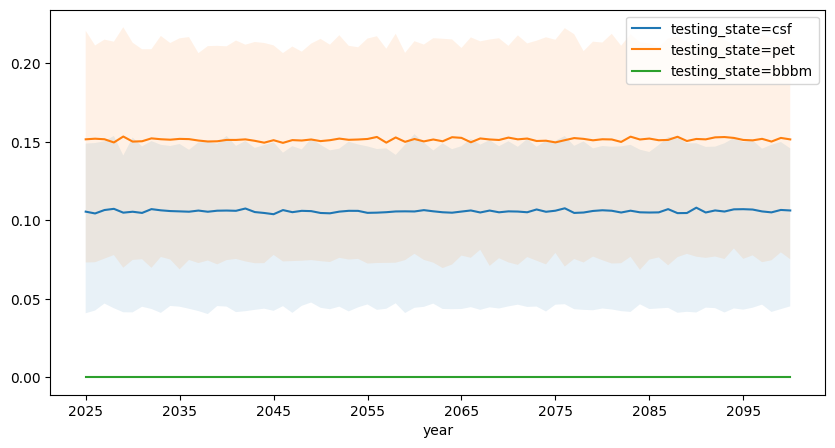

In [185]:
fig, ax = plt.subplots(figsize=(10,5))
plot_over_time_by_column(
    sim_test_rates
    .query("location == 'United States of America' and scenario == 'baseline' and testing_state != 'not_tested'"),
    'testing_state')
ax.set_xticks(ax.get_xticks()[::10])
# ax.tick_params(rotation=90)
plt.show()

# Plot existing test rates in baseline for each country

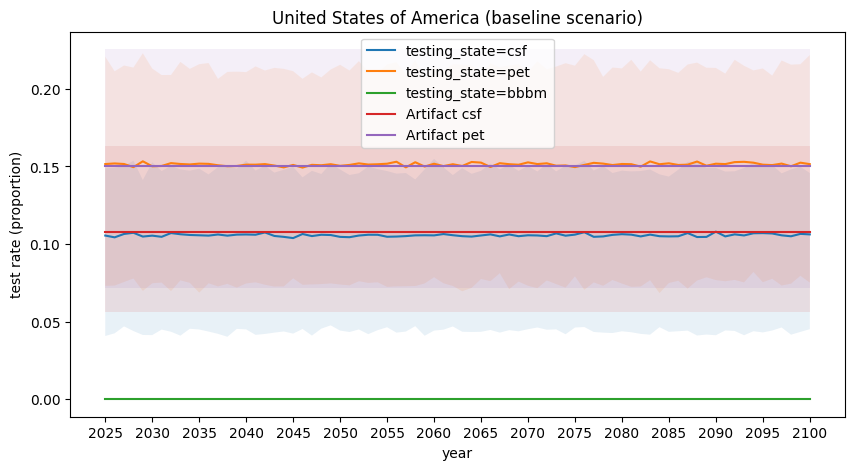

In [186]:
for location in locations:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_over_time_by_column(
        sim_test_rates
        .query("location == @location and scenario == 'baseline' and testing_state != 'not_tested'"),
        'testing_state',
        ylabel='test rate (proportion)',
        title=location + ' (baseline scenario)',
    )
    filtered_x_ticks = ax.get_xticks()[::5]
    ax.set_xticks(filtered_x_ticks)

    artifact_testing_data = summarize_artifact_data(existing_test_rates).query("location==@location")
    for test_type in artifact_testing_data.index.unique('test_type'):
        ax.plot(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'mean'], (len(filtered_x_ticks),)),
            label=f'Artifact {test_type}'
        )
        ax.fill_between(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'lower'], (len(filtered_x_ticks),)),
            np.broadcast_to(artifact_testing_data.loc[test_type, 'upper'], (len(filtered_x_ticks),)),
            alpha=.1,
        )
    # ax.tick_params(rotation=90)
    # ax.semilogy()
    # ax.set_ylim(0, 0.1)
    ax.legend()
    plt.show()

In [187]:
artifact_testing_data

,,mean,lower,upper
test_type,location,,,
csf,United States of America,0.108006,0.056326,0.163487
pet,United States of America,0.150082,0.071912,0.225537


# Plot existing tests in baseline and BBBM testing scenarios for one country

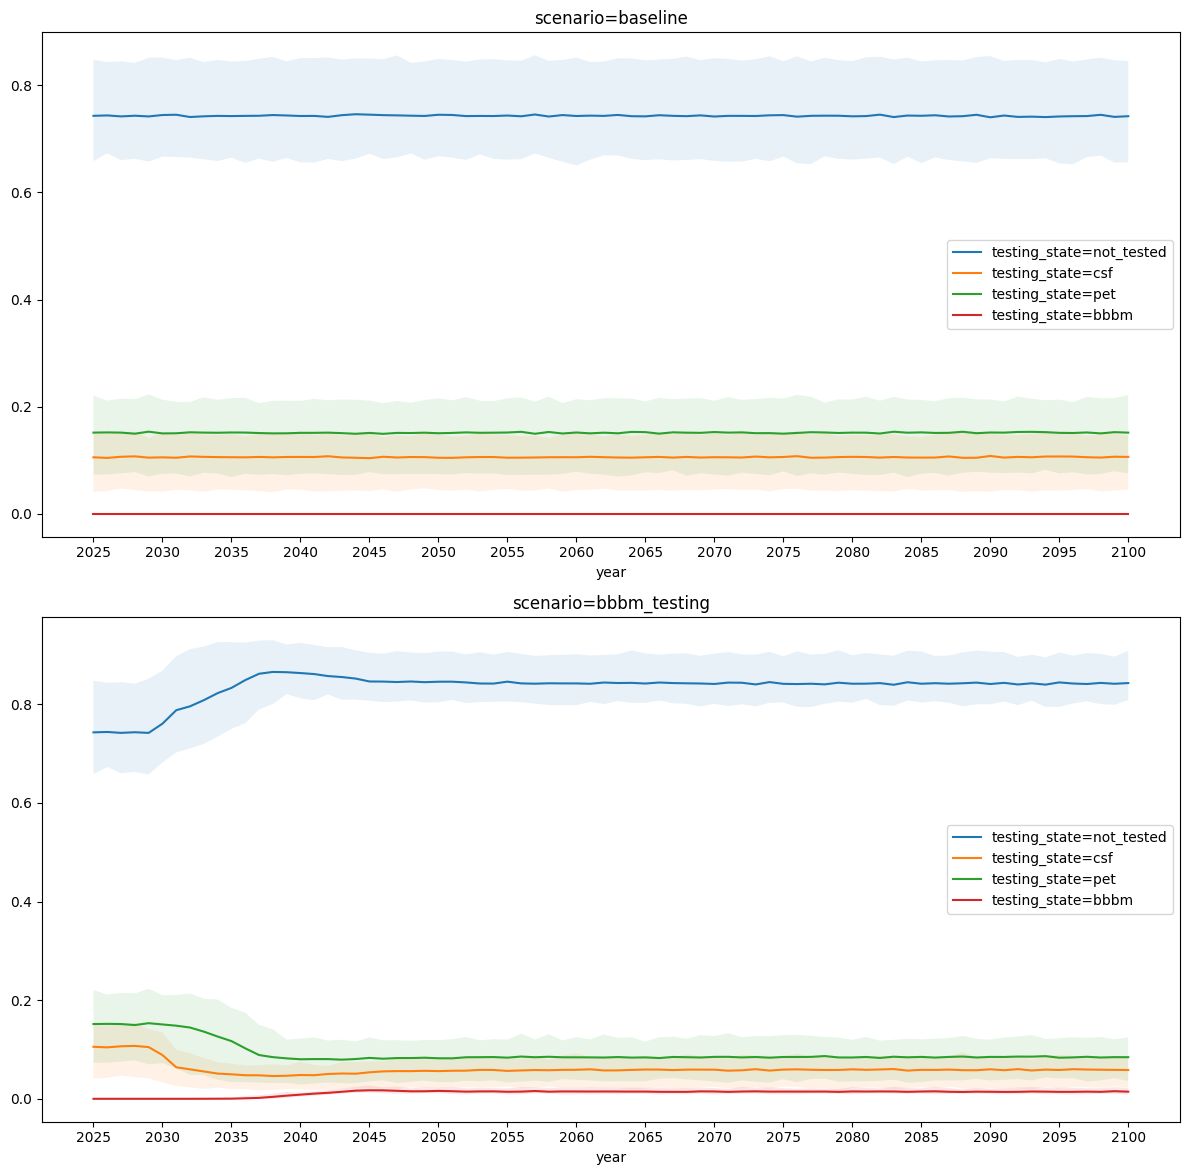

In [188]:
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("location == 'United States of America'"),
    'testing_state',
    'scenario',
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Plot existing test rates in BBBM testing scenario for all countries

Note that CSF testing always decreases before PET testing. This is due
to the way we are using the testing propensity and is undesirable
behavior that we should fix. The desired behavior is for CSF and PET
testing to decrease at the same time.

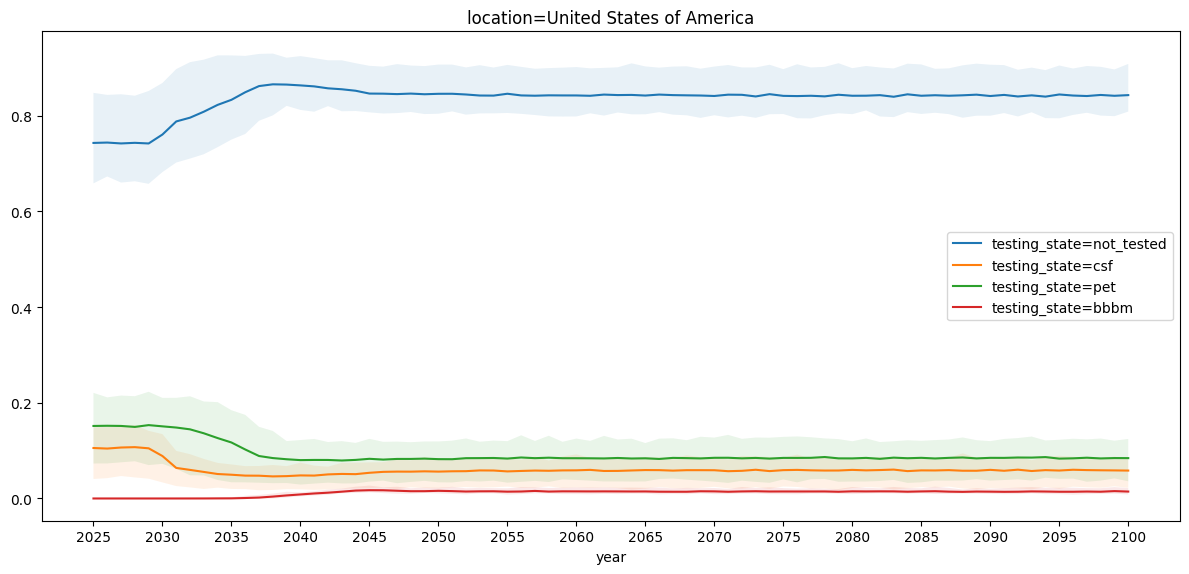

In [189]:
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("scenario == 'bbbm_testing'"),
    'testing_state',
    'location',
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Read BBBM testing data

In [190]:
bbbm_test_eligibility_counts = load_sim_output(
    'counts_newly_eligible_for_bbbm_testing',
)
bbbm_test_eligibility_counts

,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_newly_eligible_for_bbbm_testing,baseline,first,Female,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_newly_eligible_for_bbbm_testing,baseline,first,Male,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_newly_eligible_for_bbbm_testing,baseline,second,Female,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_newly_eligible_for_bbbm_testing,baseline,second,Male,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_newly_eligible_for_bbbm_testing,bbbm_testing,first,Female,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
683995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_newly_eligible_for_bbbm_testing,baseline,second,Male,0.0,United States of America
683996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_newly_eligible_for_bbbm_testing,bbbm_testing,first,Female,0.0,United States of America
683997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_newly_eligible_for_bbbm_testing,bbbm_testing,first,Male,0.0,United States of America
683998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_newly_eligible_for_bbbm_testing,bbbm_testing,second,Female,0.0,United States of America


In [191]:
bbbm_test_eligibility_counts.bbbm_test_results.unique()

['not_tested', 'positive', 'negative']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [192]:
bbbm_test_counts = load_sim_output(
    'counts_bbbm_tests',
)
bbbm_test_counts

,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,baseline,first,Female,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,baseline,first,Male,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,baseline,second,Female,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,baseline,second,Male,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,bbbm_testing,first,Female,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
683995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_bbbm_tests,baseline,second,Male,0.0,United States of America
683996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_bbbm_tests,bbbm_testing,first,Female,0.0,United States of America
683997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_bbbm_tests,bbbm_testing,first,Male,0.0,United States of America
683998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_bbbm_tests,bbbm_testing,second,Female,0.0,United States of America


# Check that BBBM tests are only occurring between ages 60-80

Yep. Good.

In [193]:
bbbm_test_eligibility_counts.query("value > 0").age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29', '30_to_34', '35_to_39', '40_to_44', ..., '80_to_84', '85_to_89', '90_to_94', '95_plus']

In [194]:
bbbm_test_counts.query("value > 0").age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29', '30_to_34', '35_to_39', '40_to_44', ..., '80_to_84', '85_to_89', '90_to_94', '95_plus']

# Divide to get BBBM testing rates for each year in each location

Aggregate over age groups and sexes to get a single number for each
location and year. Stratify by BBBM test results by broadcasting in the
numerator.

In [195]:
bbbm_test_rate = ops.ratio(
    bbbm_test_counts,
    bbbm_test_eligibility_counts,
     # Location is already in index columns, so stratify by year only
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)
bbbm_test_rate

,event_year,input_draw,scenario,location,bbbm_test_results,value,numerator_measure,denominator_measure,multiplier
0,2025,2,baseline,United States of America,not_tested,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
1,2025,2,baseline,United States of America,positive,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
2,2025,2,baseline,United States of America,negative,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
3,2025,2,bbbm_testing,United States of America,not_tested,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
4,2025,2,bbbm_testing,United States of America,positive,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...,...
11395,2100,499,baseline,United States of America,positive,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
11396,2100,499,baseline,United States of America,negative,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
11397,2100,499,bbbm_testing,United States of America,not_tested,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
11398,2100,499,bbbm_testing,United States of America,positive,0.142692,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1


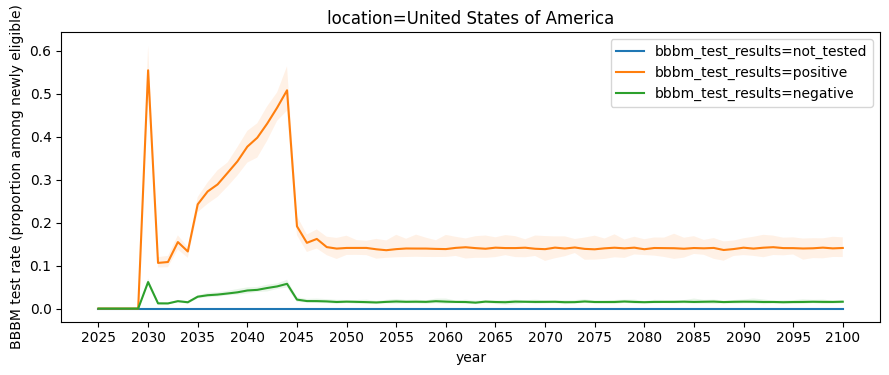

In [196]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate.query("scenario=='bbbm_testing'"),
    'bbbm_test_results',
    'location',
    ylabel='BBBM test rate (proportion among newly eligible)',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()


# Check whether `not_tested` is ever nonzero among BBBM test counts

No, it's always zero. That's good.

In [197]:
# Good -- when counting tested simulants, the results are never "not tested"
bbbm_test_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([0.])

In [198]:
# On the other hand, among eligible simulants, there are lots of people
# who haven't been tested
bbbm_test_eligibility_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([   0., 1425.,  743., ...,  902., 1024.,  920.])

# Check that among eligible similants, there are no positive tests

Yes, all counts of positive tests among eligible simulants are zero.

In [199]:
# Good -- among eligible simulants, no one has tested positive.
bbbm_test_eligibility_counts.query("bbbm_test_results == 'positive'").value.unique()

array([0.])

In [200]:
# On the other hand, among tested simulants, there are positive test results
len(bbbm_test_counts.query("bbbm_test_results == 'positive'").value.unique())

349

# Check test sensitivity

Filter to testing scenario since there are no BBBM tests in baseline.

In [201]:
# TODO: Here would be a great place to use prefilter_query in the ratio
# function, once I implement it
bbbm_test_sensitivity = ops.ratio(
    bbbm_test_counts.query("scenario=='bbbm_testing'"),
    bbbm_test_counts.query("scenario=='bbbm_testing'"),
    strata=['event_year'],
    # Broadcast in numerator to get positive and negative test results
    numerator_broadcast='bbbm_test_results',
)
bbbm_test_sensitivity

,event_year,input_draw,scenario,location,bbbm_test_results,value,numerator_measure,denominator_measure,multiplier
0,2025,2,bbbm_testing,United States of America,not_tested,NaN,counts_bbbm_tests,counts_bbbm_tests,1
1,2025,2,bbbm_testing,United States of America,positive,NaN,counts_bbbm_tests,counts_bbbm_tests,1
2,2025,2,bbbm_testing,United States of America,negative,NaN,counts_bbbm_tests,counts_bbbm_tests,1
3,2025,13,bbbm_testing,United States of America,not_tested,NaN,counts_bbbm_tests,counts_bbbm_tests,1
4,2025,13,bbbm_testing,United States of America,positive,NaN,counts_bbbm_tests,counts_bbbm_tests,1
...,...,...,...,...,...,...,...,...,...
5695,2100,480,bbbm_testing,United States of America,positive,0.883610,counts_bbbm_tests,counts_bbbm_tests,1
5696,2100,480,bbbm_testing,United States of America,negative,0.116390,counts_bbbm_tests,counts_bbbm_tests,1
5697,2100,499,bbbm_testing,United States of America,not_tested,0.000000,counts_bbbm_tests,counts_bbbm_tests,1
5698,2100,499,bbbm_testing,United States of America,positive,0.902439,counts_bbbm_tests,counts_bbbm_tests,1


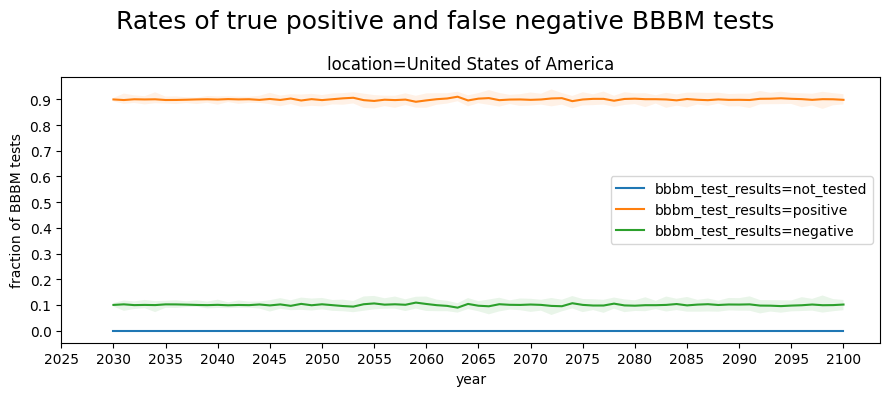

In [202]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_sensitivity,#.query("bbbm_test_results != 'not_tested'"),
    'bbbm_test_results',
    'location',
    ylabel='fraction of BBBM tests',
    suptitle='Rates of true positive and false negative BBBM tests',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
plt.show()


# Compute statistics on BBBM test sensitivity

In [203]:
bbbm_test_sensitivity_summary = ops.describe(
    bbbm_test_sensitivity.query("event_year >= '2030' and bbbm_test_results=='positive'"))
bbbm_test_sensitivity_summary

count  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario              
positive          counts_bbbm_tests   2030       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
                                      2031       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
                                      2032       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
                                      2033       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
                                      2034       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
...                                                                                                                    ...   
                                      2096       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
                                      2097       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
                                      2098       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
                                      2099       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   
                                      2100       United States of America 1          counts_bbbm_tests bbbm_testing   25.0   

                                                                                                                         mean  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario                 
positive          counts_bbbm_tests   2030       United States of America 1          counts_bbbm_tests bbbm_testing  0.899842   
                                      2031       United States of America 1          counts_bbbm_tests bbbm_testing  0.897570   
                                      2032       United States of America 1          counts_bbbm_tests bbbm_testing  0.900564   
                                      2033       United States of America 1          counts_bbbm_tests bbbm_testing  0.899825   
                                      2034       United States of America 1          counts_bbbm_tests bbbm_testing  0.900475   
...                                                                                                                       ...   
                                      2096       United States of America 1          counts_bbbm_tests bbbm_testing  0.901084   
                                      2097       United States of America 1          counts_bbbm_tests bbbm_testing  0.898293   
                                      2098       United States of America 1          counts_bbbm_tests bbbm_testing  0.900948   
                                      2099       United States of America 1          counts_bbbm_tests bbbm_testing  0.900520   
                                      2100       United States of America 1          counts_bbbm_tests bbbm_testing  0.898365   

                                                                                                                          std  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario                 
positive          counts_bbbm_tests   2030       United States of America 1          counts_bbbm_tests bbbm_testing  0.003867   
                                      2031       United States of America 1          counts_bbbm_tests bbbm_testing  0.010354   
                                      2032       United States of America 1          counts_bbbm_tests bbbm_testing  0.009030   
                                      2033       United States of America 1          counts_bbbm_tests bbbm_testing  0.009666   
                          

In [204]:
bbbm_test_sensitivity_summary['mean'].describe()

count    71.000000
mean      0.899915
std       0.003127
min       0.890790
25%       0.897967
50%       0.899876
75%       0.901668
max       0.910484
Name: mean, dtype: float64

# Compute test result fractions among newly eligible simulants

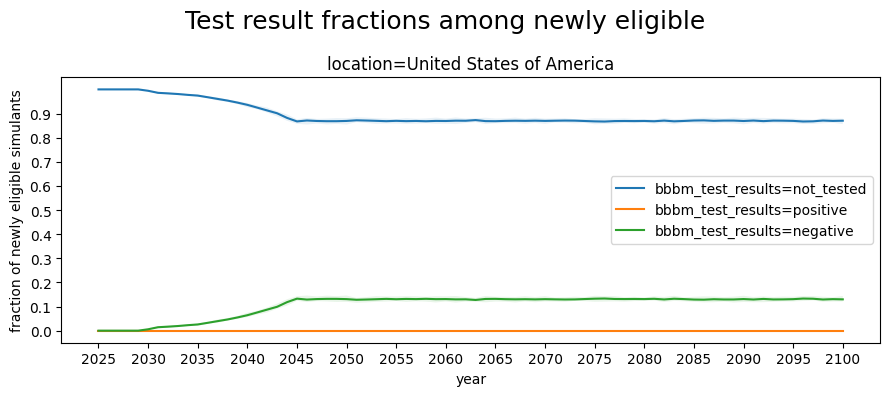

In [205]:
# TODO: Here would be a great place to use prefilter_query in the ratio
# function, once I implement it
bbbm_test_result_fractions_among_eligible = ops.ratio(
    bbbm_test_eligibility_counts.query("scenario=='bbbm_testing'"),
    bbbm_test_eligibility_counts.query("scenario=='bbbm_testing'"),
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)

fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_result_fractions_among_eligible,
    'bbbm_test_results',
    'location',
    ylabel='fraction of newly eligible simulants',
    suptitle='Test result fractions among newly eligible',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
plt.show()

# Plot numerators and denominators of BBBM test rate

In [206]:
bbbm_test_rate_numerator = ops.stratify(bbbm_test_counts, 'event_year')
bbbm_test_rate_denominator = ops.stratify(bbbm_test_eligibility_counts, 'event_year')
bbbm_test_rate_num_and_denom = pd.concat(
    [bbbm_test_rate_numerator, bbbm_test_rate_denominator],
    keys=['tests', 'newly_eligible'],
    names=['count'],
).reset_index('count').reset_index(drop=True)
bbbm_test_rate_num_and_denom

,count,event_year,input_draw,scenario,location,value
0,tests,2025,356,baseline,United States of America,0.0
1,tests,2025,356,bbbm_testing,United States of America,0.0
2,tests,2025,346,baseline,United States of America,0.0
3,tests,2025,346,bbbm_testing,United States of America,0.0
4,tests,2025,113,baseline,United States of America,0.0
...,...,...,...,...,...,...
7595,newly_eligible,2100,41,bbbm_testing,United States of America,2765.0
7596,newly_eligible,2100,24,baseline,United States of America,6560.0
7597,newly_eligible,2100,24,bbbm_testing,United States of America,3020.0
7598,newly_eligible,2100,317,baseline,United States of America,5636.0


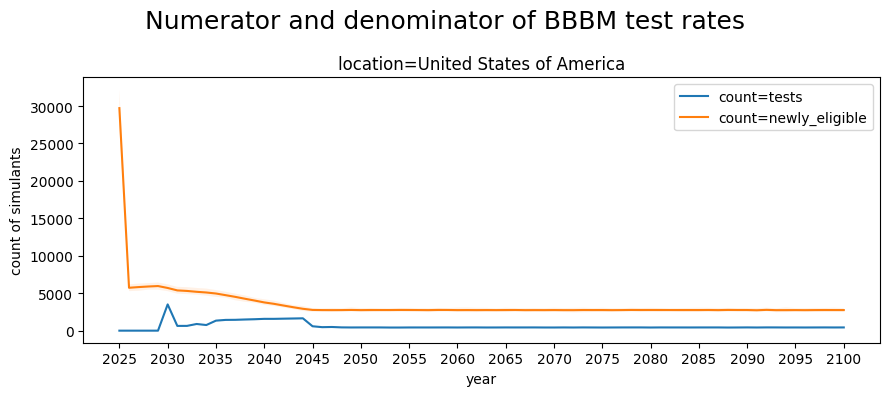

In [207]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate_num_and_denom.query("scenario=='bbbm_testing'"),
    'count',
    'location',
    ylabel='count of simulants',
    suptitle='Numerator and denominator of BBBM test rates',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Read in BBBM testing person-time data

In [208]:
pt_ever_eligible_bbbm = load_sim_output(
    'person_time_ever_eligible_for_bbbm_testing'
)
pt_ever_eligible_bbbm

,age_group,alzheimers_disease_and_other_dementias,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,value,location
0,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,first,Female,0.000000,United States of America
1,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,first,Male,0.000000,United States of America
2,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,second,Female,0.000000,United States of America
3,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,second,Male,0.000000,United States of America
4,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Female,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051995,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,baseline,second,Male,0.000000,United States of America
2051996,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Female,10.464066,United States of America
2051997,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Male,5.481177,United States of America
2051998,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,second,Female,11.958932,United States of America


In [209]:
pt_eligible_bbbm = load_sim_output(
    'person_time_eligible_for_bbbm_testing'
)
pt_eligible_bbbm

,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_eligible_for_bbbm_testing,baseline,first,Female,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_eligible_for_bbbm_testing,baseline,first,Male,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_eligible_for_bbbm_testing,baseline,second,Female,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_eligible_for_bbbm_testing,baseline,second,Male,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_eligible_for_bbbm_testing,bbbm_testing,first,Female,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
683995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_eligible_for_bbbm_testing,baseline,second,Male,0.0,United States of America
683996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_eligible_for_bbbm_testing,bbbm_testing,first,Female,0.0,United States of America
683997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_eligible_for_bbbm_testing,bbbm_testing,first,Male,0.0,United States of America
683998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_eligible_for_bbbm_testing,bbbm_testing,second,Female,0.0,United States of America


# Plot BBBM testing rate (counts / eligible person-time)

In [210]:
bbbm_tests_per_eligible_pt = ops.ratio(
    bbbm_test_counts,
    pt_eligible_bbbm,
    strata='event_year',
    # numerator_broadcast='bbbm_test_results',
)
bbbm_tests_per_eligible_pt

,event_year,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2025,356,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
1,2025,356,bbbm_testing,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
2,2025,346,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3,2025,346,bbbm_testing,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
4,2025,113,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...
3795,2100,41,bbbm_testing,United States of America,0.033061,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3796,2100,24,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3797,2100,24,bbbm_testing,United States of America,0.037821,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3798,2100,317,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1


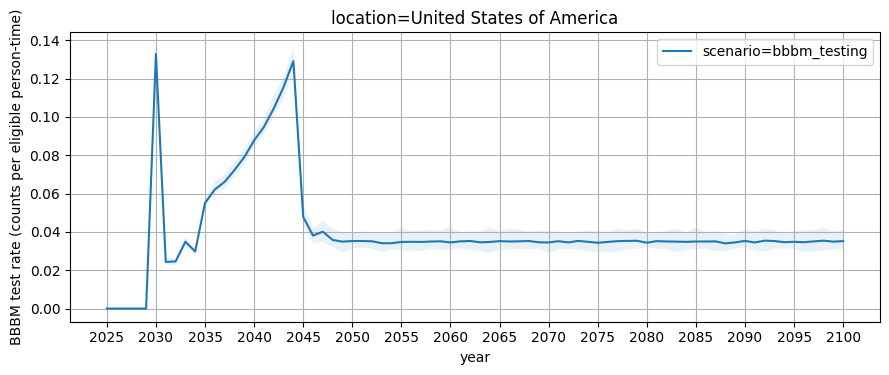

In [211]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_tests_per_eligible_pt.query("scenario=='bbbm_testing'"),
    # 'bbbm_test_results',
    'scenario',
    'location',
    ylabel='BBBM test rate (counts per eligible person-time)',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::5])
    ax.grid(True)
plt.show()


# Compute prevalence of ever tested among ever eligible

In [212]:
pt_ever_eligible_bbbm.bbbm_test_results.unique()

['not_tested', 'positive', 'negative']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [213]:
pt_ever_eligible_bbbm

,age_group,alzheimers_disease_and_other_dementias,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,value,location
0,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,first,Female,0.000000,United States of America
1,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,first,Male,0.000000,United States of America
2,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,second,Female,0.000000,United States of America
3,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,second,Male,0.000000,United States of America
4,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Female,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051995,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,baseline,second,Male,0.000000,United States of America
2051996,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Female,10.464066,United States of America
2051997,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Male,5.481177,United States of America
2051998,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,second,Female,11.958932,United States of America


In [214]:
# TODO: Another place for using prefilter_query
ever_tested_over_ever_eligible = ops.ratio(
    pt_ever_eligible_bbbm.query(
        "bbbm_test_results != 'not_tested' and alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'"),
    pt_ever_eligible_bbbm.query("alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'"),
    strata=['event_year', 'age_group'],
).query("scenario == 'bbbm_testing'")
ever_tested_over_ever_eligible

,event_year,age_group,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
1,2025,25_to_29,356,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
3,2025,25_to_29,346,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
5,2025,25_to_29,113,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
7,2025,25_to_29,273,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
9,2025,25_to_29,499,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...,...
56991,2100,95_plus,323,bbbm_testing,United States of America,0.665944,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
56993,2100,95_plus,2,bbbm_testing,United States of America,0.606583,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
56995,2100,95_plus,41,bbbm_testing,United States of America,0.619485,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
56997,2100,95_plus,24,bbbm_testing,United States of America,0.615681,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1


In [215]:
ever_tested_over_ever_eligible['age_group']

1        25_to_29
3        25_to_29
5        25_to_29
7        25_to_29
9        25_to_29
           ...   
56991     95_plus
56993     95_plus
56995     95_plus
56997     95_plus
56999     95_plus
Name: age_group, Length: 28500, dtype: category
Categories (15, object): ['25_to_29', '30_to_34', '35_to_39', '40_to_44', ..., '80_to_84', '85_to_89', '90_to_94', '95_plus']

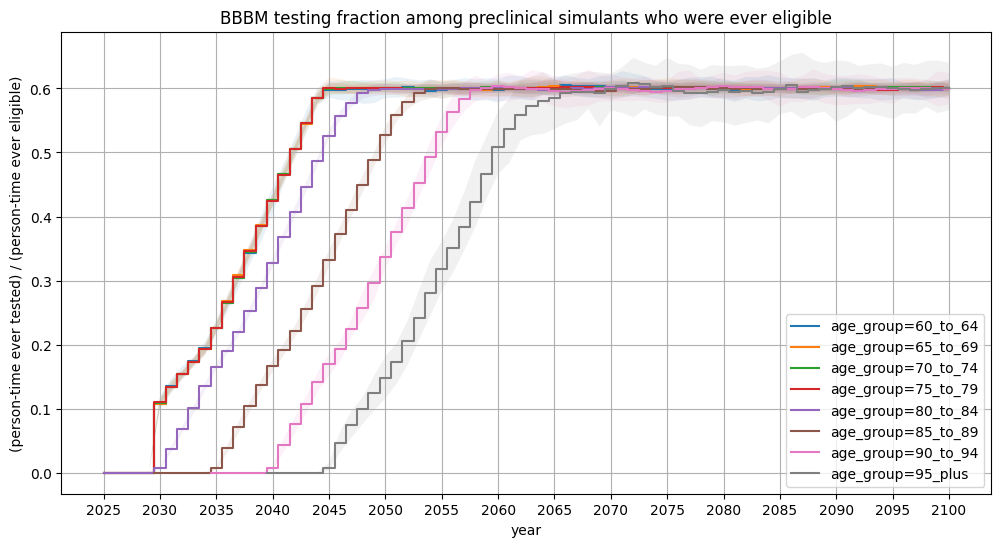

In [216]:
# NOTE: I got "ValueError: unknown type object" when calling 
# .query("age_group < '60_to_64'") -- I fixed this by converting the
# dtype from Categorical to string. Using .loc doesn't work either
# because you can't compare unordered Categoricals. If we used an
# ordered Categorical for the age groups, that might make this easier.
fig, ax = plt.subplots(figsize=(12, 6))
plot_over_time_by_column(
    ever_tested_over_ever_eligible.astype({'age_group': str})
        .query("age_group >= '60_to_64'"),
        #.loc[ever_tested_over_ever_eligible.age_group < '60_to_64'],
        # .query("age_group in ['60_to_64', '65_to_69', '70_to_74', '75_to_79']"),
    'age_group',
    ax=ax,
    ylabel='(person-time ever tested) / (person-time ever eligible)',
    title='BBBM testing fraction among preclinical simulants who were ever eligible',
    # plot_func='step',
    # where='post',
    ds='steps-mid',
)
ax.set_xticks(ax.get_xticks()[::5])
ax.grid(True)
plt.show()
